In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Project Repo

https://github.com/vinothmdev/CNN_Cancer_Detection.git

# Description of the problem and data

The challenge is to classify histopathologic images into cancerous and non-cancerous categories using a CNN. The dataset consists of thousands of RGB images, each resized to 128x128 pixels, organized into training and test directories. This task involves image preprocessing, data augmentation, and model training using deep learning techniques.



In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import seaborn as sns

2024-06-11 17:37:31.551401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 17:37:31.551496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 17:37:31.685496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
os.listdir('/kaggle/input/histopathologic-cancer-detection/')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

## Constants

In [5]:
INPUT_DIR_PATH = '/kaggle/input/histopathologic-cancer-detection/'
TRAINING_LABELS_FILE = INPUT_DIR_PATH + 'train_labels.csv'
TEST_LABELS_FILE = INPUT_DIR_PATH + 'sample_submission.csv'
TRAIN_DIR_PATH = '/kaggle/input/histopathologic-cancer-detection/train'
TEST_DIR_PATH = '/kaggle/input/histopathologic-cancer-detection/test'

In [6]:
# Read the input labels
train_labels_df = pd.read_csv(TRAINING_LABELS_FILE)
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
# Data Inspection
labels = train_labels_df['label'].value_counts()
negatives = train_labels_df.loc[train_labels_df['label']==0]
positives = train_labels_df.loc[train_labels_df['label']==1]
print(f'Shape of given data {train_labels_df.shape}')
print(f'There are {len(negatives)} negatives and {len(positives)} positives in the input data set')
print(f'Number of duplicates in the data {len(train_labels_df[train_labels_df.duplicated(keep=False)])}')

Shape of given data (220025, 2)
There are 130908 negatives and 89117 positives in the input data set
Number of duplicates in the data 0


# Training Data Visualization

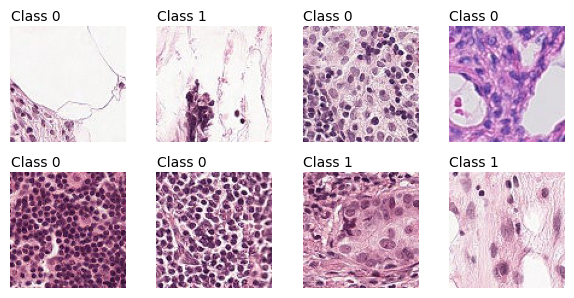

In [8]:
plt.figure(figsize=(6,6))

for i, row in train_labels_df[:8].iterrows():

    img = mpimg.imread(f'{INPUT_DIR_PATH}train/{row.id}.tif')    
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
train_labels_df.id = train_labels_df.id + '.tif'
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [10]:
training_df, validation_df = train_test_split(train_labels_df, test_size=0.2, random_state=1, stratify=train_labels_df.label)

In [11]:
training_df.head()

,id,label
169632,05afcb247924970d9c7c17ccf956db20f8b626f3.tif,0
48553,55e47dbf379817bf65ba25ac599a639638a44bbb.tif,0
165988,836b2171417da27f68be363c80fd53e0319f875f.tif,1
48724,8ff04d223f6ce6d707565e9cf19ca4f040e6b8d5.tif,0
173841,af80e9b4701f43eb0354dc58088186a1a76f897a.tif,1


In [12]:
print("train data size:", len(training_df))
print("validation data size:", len(validation_df))

train data size: 176020
validation data size: 44005


In [13]:
train_size = len(training_df)
validation_size = len(validation_df)
batch_size = 250


train_steps = int(np.ceil(train_size / batch_size))
validation_steps = int(np.ceil(validation_size / batch_size))

print(f'train steps {train_steps}, validation steps {validation_steps}')

train steps 705, validation steps 177


## Image Data Generators

In [14]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

In [15]:
# Data augmentation and preprocessing
train_loader = train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=TRAIN_DIR_PATH,
    x_col='id',
    y_col='label',
    batch_size=64,
    seed=1,
    shuffle=True,
    class_mode='raw',
    target_size=(96, 96)
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=TRAIN_DIR_PATH,
    x_col='id',
    y_col='label',
    batch_size=64,
    seed=1,
    shuffle=True,
    class_mode='raw',
    target_size=(96, 96)
)


Found 176020 validated image filenames.
Found 44005 validated image filenames.


In [16]:
def build_model(dropout_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [17]:
model = build_model(0.5)
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,761 (30.33 MB)

 Trainable params: 7,949,761 (30.33 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

In [19]:
%%time
history = model.fit(train_loader,
                    epochs=10,
                    steps_per_epoch=train_steps,
                    validation_data=valid_loader,
                    validation_steps=validation_steps)

Epoch 1/10


2024-06-11 17:42:14.768523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.24101, expected 6.3775
2024-06-11 17:42:14.768583: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.64874, expected 5.78524
2024-06-11 17:42:14.768592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 7.29211, expected 6.42861
2024-06-11 17:42:14.768600: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 7.40292, expected 6.53942
2024-06-11 17:42:14.768611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 6.8235, expected 5.96
2024-06-11 17:42:14.768619: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15: 7.36768, expected 6.50417
2024-06-11 17:42:14.768627: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 6.8738, expected 6.01029
2024-06-11 17:42:14.768635: E external/local_xla/xla/ser

  1/705 ━━━━━━━━━━━━━━━━━━━━ 1:46:34 9s/step - accuracy: 0.5625 - loss: 0.7106

I0000 00:00:1718127738.193352      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


705/705 ━━━━━━━━━━━━━━━━━━━━ 281s 386ms/step - accuracy: 0.6686 - loss: 0.7510 - val_accuracy: 0.7782 - val_loss: 0.5067
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 222s 315ms/step - accuracy: 0.7672 - loss: 0.5318 - val_accuracy: 0.7741 - val_loss: 0.4918
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 182s 259ms/step - accuracy: 0.7653 - loss: 0.5212 - val_accuracy: 0.6915 - val_loss: 0.5488
Epoch 4/10
144/705 ━━━━━━━━━━━━━━━━━━━━ 1:34 169ms/step - accuracy: 0.7550 - loss: 0.5199

2024-06-11 17:53:59.546128: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44180: 7.15656, expected 6.24082
2024-06-11 17:53:59.546182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44181: 8.03765, expected 7.12192
2024-06-11 17:53:59.546201: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44182: 7.32376, expected 6.40803
2024-06-11 17:53:59.546214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44183: 6.00329, expected 5.08755
2024-06-11 17:53:59.546226: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44184: 6.93475, expected 6.01901
2024-06-11 17:53:59.546236: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44185: 7.6303, expected 6.71456
2024-06-11 17:53:59.546247: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44186: 7.59534, expected 6.6796
2024-06-11 17:53:59.546258: E

634/705 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.7630 - loss: 0.5162

2024-06-11 17:55:50.327469: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8838: 6.40036, expected 5.61054
2024-06-11 17:55:50.327525: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 6.30832, expected 5.5185
2024-06-11 17:55:50.327539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8840: 6.20049, expected 5.41068
2024-06-11 17:55:50.327552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8843: 6.26595, expected 5.47613
2024-06-11 17:55:50.327570: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8844: 6.39293, expected 5.60312
2024-06-11 17:55:50.327581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 6.59253, expected 5.80272
2024-06-11 17:55:50.327591: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8846: 6.54231, expected 5.7525
2024-06-11 17:55:50.327602: E extern

705/705 ━━━━━━━━━━━━━━━━━━━━ 137s 194ms/step - accuracy: 0.7635 - loss: 0.5157 - val_accuracy: 0.7966 - val_loss: 0.4808
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 142s 200ms/step - accuracy: 0.7636 - loss: 0.5217 - val_accuracy: 0.7998 - val_loss: 0.4584
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 123s 174ms/step - accuracy: 0.7764 - loss: 0.5011 - val_accuracy: 0.7703 - val_loss: 0.4845
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 114s 162ms/step - accuracy: 0.7798 - loss: 0.4915 - val_accuracy: 0.7785 - val_loss: 0.4698
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 92s 131ms/step - accuracy: 0.7813 - loss: 0.4908 - val_accuracy: 0.7742 - val_loss: 0.4697
Epoch 9/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 101s 142ms/step - accuracy: 0.7897 - loss: 0.4872 - val_accuracy: 0.8089 - val_loss: 0.4377
Epoch 10/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 96s 137ms/step - accuracy: 0.7847 - loss: 0.4796 - val_accuracy: 0.8092 - val_loss: 0.4450
CPU times: user 9min 32s, sys: 51.8 s, total: 10min 23s
Wall time: 25min 16s


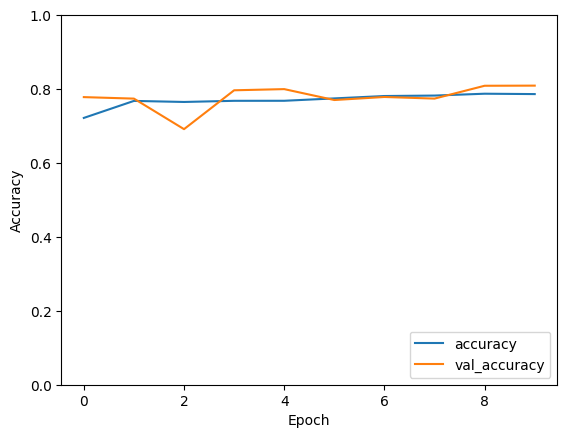

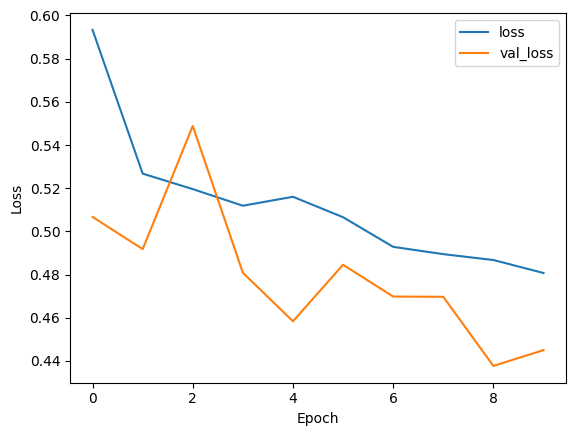

In [20]:
# Plot the accuracy and loss curves
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [21]:
test_df = pd.read_csv(TEST_LABELS_FILE)
test_df.id = test_df.id + '.tif'
test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [22]:
%%time

test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = TEST_DIR_PATH,
    batch_size = 64,
    shuffle = False,
    target_size = (96,96),
    x_col='id',
    y_col='label',
    class_mode='raw'
)

Found 57458 validated image filenames.
CPU times: user 981 ms, sys: 1.16 s, total: 2.14 s
Wall time: 1min 49s


In [23]:
# Get the true labels and predicted labels
Y_pred = model.predict(test_loader)


897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step

2024-06-11 18:13:47.223727: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9311: 4.88192, expected 4.257
2024-06-11 18:13:47.223789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9427: 4.95022, expected 4.3253
2024-06-11 18:13:47.223801: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10075: 5.2489, expected 4.62398
2024-06-11 18:13:47.223809: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10094: 4.84748, expected 4.22256
2024-06-11 18:13:47.223817: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10099: 5.04175, expected 4.41683
2024-06-11 18:13:47.223825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10193: 5.11325, expected 4.48833
2024-06-11 18:13:47.223833: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10206: 5.16487, expected 4.53995
2024-06-11 18:13:47.223841: E ext

898/898 ━━━━━━━━━━━━━━━━━━━━ 272s 303ms/step


              precision    recall  f1-score   support

           0       1.00      0.67      0.80     57458
           1       0.00      0.00      0.00         0

    accuracy                           0.67     57458
   macro avg       0.50      0.33      0.40     57458
weighted avg       1.00      0.67      0.80     57458



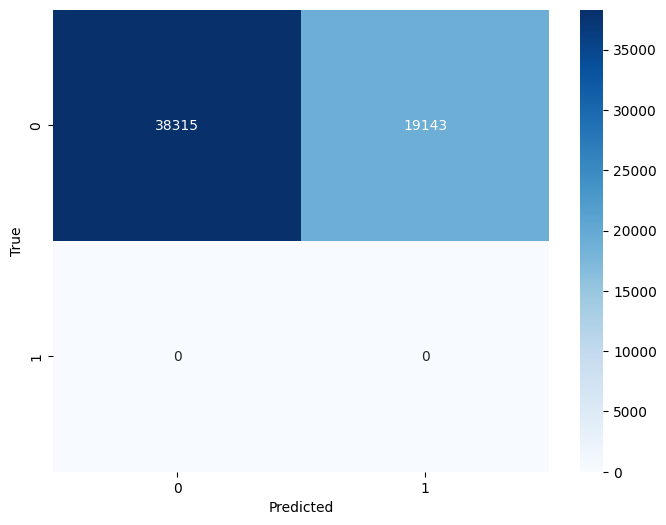

In [24]:
y_pred = np.round(Y_pred).astype(int).ravel()
y_true = test_df['label']

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optimizer Tuning

In [25]:
results = []

In [26]:
%%time

optimizers = {
    'Adam': Adam(),
    'RMSprop': RMSprop(),
    'SGD': SGD()
}

for opt_name, optimizer in optimizers.items():
    model = build_model(0.5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
                    train_loader,
                    epochs=10,
                    steps_per_epoch=train_steps,
                    validation_data=valid_loader,
                    validation_steps=validation_steps
    )
    
    results.append({
        'Hyperparameter': 'Optimizer',
        'Value': opt_name,
        'Train Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1]
    })

Epoch 1/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 102s 139ms/step - accuracy: 0.5796 - loss: 0.8146 - val_accuracy: 0.5955 - val_loss: 0.6146
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step - accuracy: 0.6927 - loss: 0.5787 - val_accuracy: 0.7700 - val_loss: 0.5156
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 84s 119ms/step - accuracy: 0.7642 - loss: 0.5276 - val_accuracy: 0.7758 - val_loss: 0.5001
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.7659 - loss: 0.5168 - val_accuracy: 0.7881 - val_loss: 0.4805
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 79s 111ms/step - accuracy: 0.7669 - loss: 0.5132 - val_accuracy: 0.7916 - val_loss: 0.4726
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.7772 - loss: 0.4991 - val_accuracy: 0.7473 - val_loss: 0.5153
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.7789 - loss: 0.4953 - val_accuracy: 0.8023 - val_loss: 0.4592
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 69s 98ms/step - accuracy: 0.7846 - loss: 0

# Learning Rate Tuning

In [27]:
%%time
learning_rates = [0.001, 0.0001, 0.01]
for lr in learning_rates:
    model = build_model(0.5)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])   
    history = model.fit(
                    train_loader,
                    epochs=10,
                    steps_per_epoch=train_steps,
                    validation_data=valid_loader,
                    validation_steps=validation_steps
    )
    
    results.append({
        'Hyperparameter': 'Learning Rate',
        'Value': lr,
        'Train Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1]
    })    

Epoch 1/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 79s 107ms/step - accuracy: 0.7193 - loss: 0.6287 - val_accuracy: 0.7809 - val_loss: 0.4679
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.7838 - loss: 0.4790 - val_accuracy: 0.8048 - val_loss: 0.4426
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 74s 106ms/step - accuracy: 0.7979 - loss: 0.4598 - val_accuracy: 0.7854 - val_loss: 0.4496
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.8026 - loss: 0.4531 - val_accuracy: 0.8147 - val_loss: 0.4222
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.8088 - loss: 0.4424 - val_accuracy: 0.7916 - val_loss: 0.4445
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 89s 127ms/step - accuracy: 0.8047 - loss: 0.4463 - val_accuracy: 0.8026 - val_loss: 0.4233
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 90s 128ms/step - accuracy: 0.8060 - loss: 0.4431 - val_accuracy: 0.7436 - val_loss: 0.5455
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8098 - loss: 0.

# Dropout Rate Tuning

In [28]:
%%time

dropout_rates = [0.3, 0.5, 0.7]

for dropout_rate in dropout_rates:
    model = build_model(dropout_rate)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
                    train_loader,
                    epochs=10,
                    steps_per_epoch=train_steps,
                    validation_data=valid_loader,
                    validation_steps=validation_steps
    )
    
    results.append({
        'Hyperparameter': 'Dropout Rate',
        'Value': dropout_rate,
        'Train Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1]
    })    

Epoch 1/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 84s 114ms/step - accuracy: 0.6328 - loss: 0.7360 - val_accuracy: 0.7833 - val_loss: 0.4763
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.7685 - loss: 0.5095 - val_accuracy: 0.7973 - val_loss: 0.4588
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 75s 106ms/step - accuracy: 0.7929 - loss: 0.4720 - val_accuracy: 0.7811 - val_loss: 0.4658
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 70s 99ms/step - accuracy: 0.7999 - loss: 0.4583 - val_accuracy: 0.8011 - val_loss: 0.4370
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 84s 118ms/step - accuracy: 0.7986 - loss: 0.4533 - val_accuracy: 0.8126 - val_loss: 0.4190
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 83s 118ms/step - accuracy: 0.8086 - loss: 0.4417 - val_accuracy: 0.8161 - val_loss: 0.4073
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 85s 120ms/step - accuracy: 0.8152 - loss: 0.4275 - val_accuracy: 0.8252 - val_loss: 0.3961
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.8121 - loss: 0.

In [30]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Hyperparameter Tuning Results", dataframe=results_df)
print(results_df)

  Hyperparameter    Value  Train Accuracy  Validation Accuracy
0      Optimizer     Adam        0.786148             0.803672
1      Optimizer  RMSprop        0.773559             0.805085
2      Optimizer      SGD        0.793661             0.788047
3  Learning Rate    0.001        0.817198             0.825653
4  Learning Rate   0.0001        0.818129             0.820180
5  Learning Rate     0.01        0.595146             0.592161
6   Dropout Rate      0.3        0.822584             0.777013
7   Dropout Rate      0.5        0.809100             0.816649
8   Dropout Rate      0.7        0.762744             0.794315


In [31]:
model.save('HCDv01.h5')

In [34]:
import pickle
pickle.dump(history, open(f'HCDv01.pkl', 'wb'))

In [35]:
submission = pd.read_csv(TEST_LABELS_FILE)
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [37]:
Y_pred

array([[0.05956953],
       [0.68394256],
       [0.00498114],
       ...,
       [0.19077587],
       [0.01212735],
       [0.18162918]], dtype=float32)

In [38]:
test_pred = np.argmax(Y_pred, axis=1)
print(test_pred[:10])

[0 0 0 0 0 0 0 0 0 0]


In [41]:
submission.label = test_pred[:]
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [42]:
submission.to_csv('submission.csv', header=True, index=False)